### TO DO:
- LC and Controls Data interpolate Missing power data :D -> turned out that missing power data was RECOVERY data, and that end_exercise wasn't properly adjusted
- Integrate correction in code -> integrated all corrections in either preprocessing, or the processing function as a separate function that can be turned on or off at leisure
- See if Data before SOM makes sense
- Solve the SOM map issue -> Apparently the linspace had to be set to the highest power, it was power based, and now I got a good heat map. However, this part does not affect the Movement deviation profile
- Take care of movement deviation profile
- See if Data After SOM creation makes sense

In [ ]:
import os
import sys
import random
import copy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# get the current working directory
cwd = os.getcwd()
# append the \SOM_package directory to the system path
sys.path.append(cwd + '\SOM_package')
from som_make import som_make
from som_bmus import som_bmus
from som_ind2sub import som_ind2sub
from som_denormalize import som_denormalize
from Functions import process_data, determine_longest_trial, Create_som, subplot_mdp


In [2]:
data_paths = ['ME.data', 'LC.data', 'Controls.data']
length_prime = 0
exercise_df = {}
for data_p in data_paths:
    data_name = data_p.split('.')[0]
    exercise_df[data_name] = process_data(data_p)
    length = determine_longest_trial(exercise_df[data_name])
    if length > length_prime:
        length_prime = length
length_prime = length_prime + 1

for key in exercise_df.keys():
    exercise_df[key].loc[exercise_df[key]['t'] > 6, 't'] = np.nan
    sData_exercise, sData_exercise_copy, sData_exercise_norm, compnames = Create_som(exercise_df[key], length_prime)
    if key == 'ME':
        sData_ME = sData_exercise.copy()
        sData_ME_copy = sData_exercise_copy.copy()
        sData_ME_norm = sData_exercise_norm.copy()
        sData_ME_norm_copy = copy.deepcopy(sData_ME_norm)
        plotdata_ME = sData_ME['data'].copy()
    elif key == 'LC':
        sData_LC = sData_exercise.copy()
        sData_LC_copy = sData_exercise_copy.copy()
        sData_LC_norm = sData_exercise_norm.copy()
        sData_LC_norm_copy = copy.deepcopy(sData_LC_norm)
        plotdata_LC = sData_LC['data'].copy()
    elif key == 'Controls':
        sData_controls = sData_exercise.copy()
        sData_controls_copy = sData_exercise_copy.copy()
        sData_controls_norm = sData_exercise_norm.copy()
        sData_controls_norm_copy = copy.deepcopy(sData_controls_norm)
        plotdata_controls = sData_controls['data'].copy()  
    else:
        print('Error in data reading: Weird data path')

In [3]:
sData_controls_norm['labels'] = sData_controls['labels'].copy()
### change n to sample size control group
n = 25
participants = random.sample(list(np.unique(sData_controls['labels'])), n)
indices = np.where(np.isin(sData_controls['labels'], participants))[0]
print(indices.shape)
sData_controls_norm_train = copy.deepcopy(sData_controls_norm)
sData_controls_norm_train['data'] = sData_controls_norm_train['data'][indices]
sData_controls_norm_train['labels'] = sData_controls_norm_train['labels'][indices]
sData_controls_norm_test = copy.deepcopy(sData_controls_norm)
sData_controls_norm_test['data'] = np.delete(sData_controls_norm_test['data'], indices, axis=0)
sData_controls_norm_test['labels'] = np.delete(sData_controls_norm_test['labels'], indices, axis=0)



(10850,)


Determining map size...
 sTopol first round done
Map size [35, 15]
Initialization...
 sTopol first round done
Training using batch algorithm...
Rough training phase...
Training: 0 / 0 s

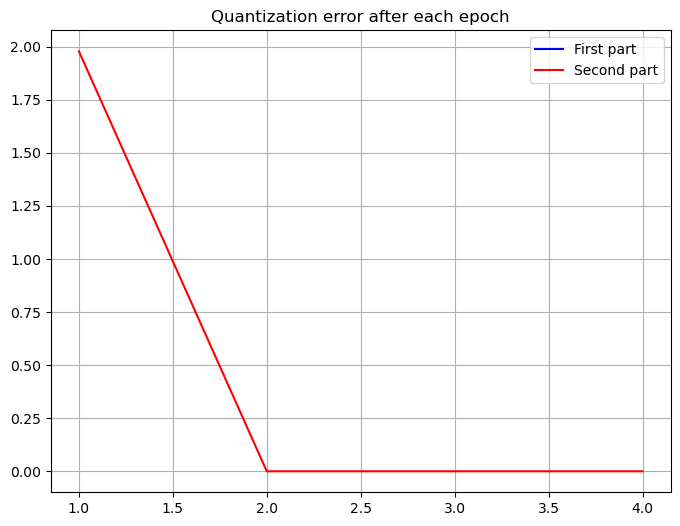

Training: 0 / 1 s

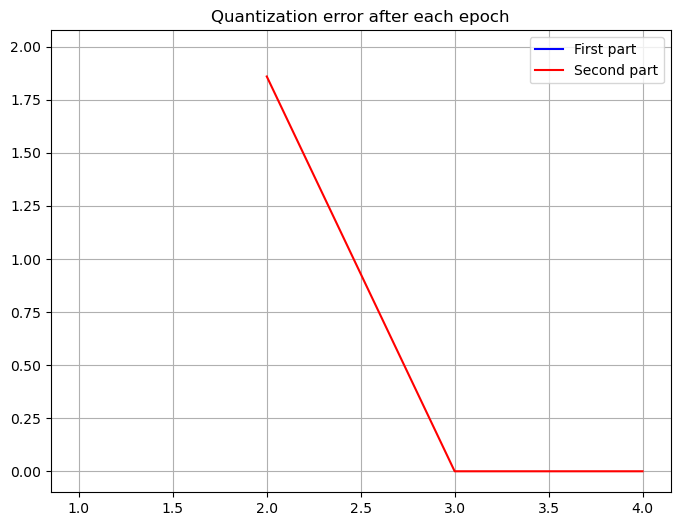

Training: 1 / 1 s

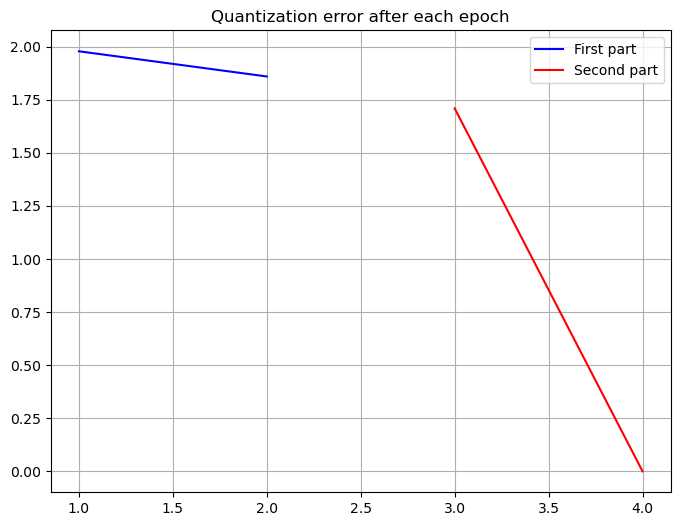

Training: 1 / 1 s

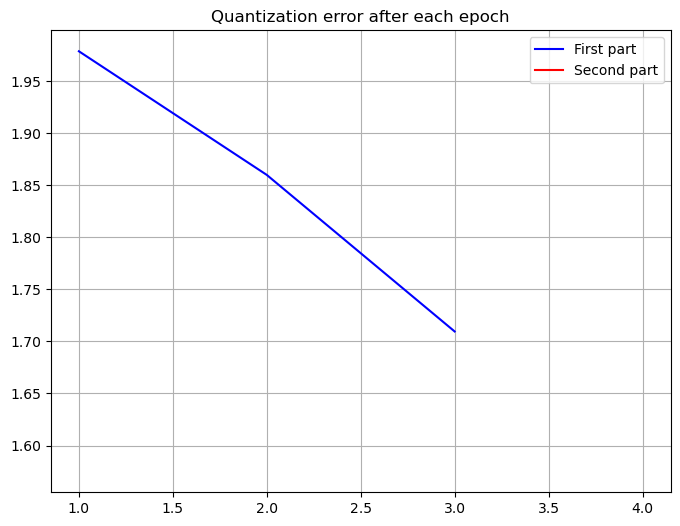



finetuning phase...
Training: 0 / 0 s

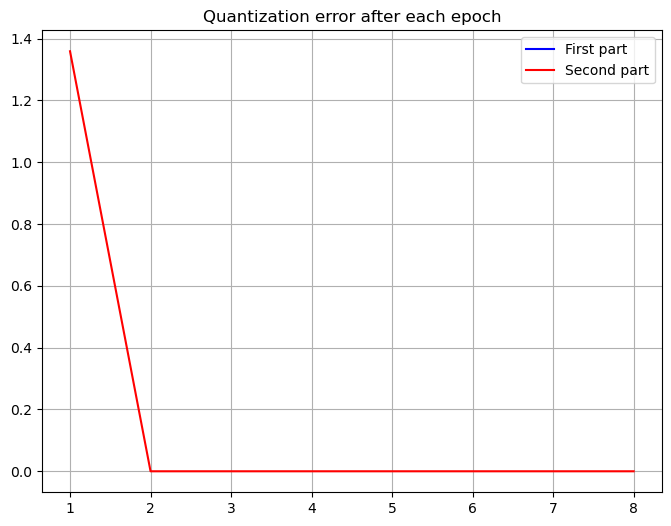

Training: 0 / 1 s

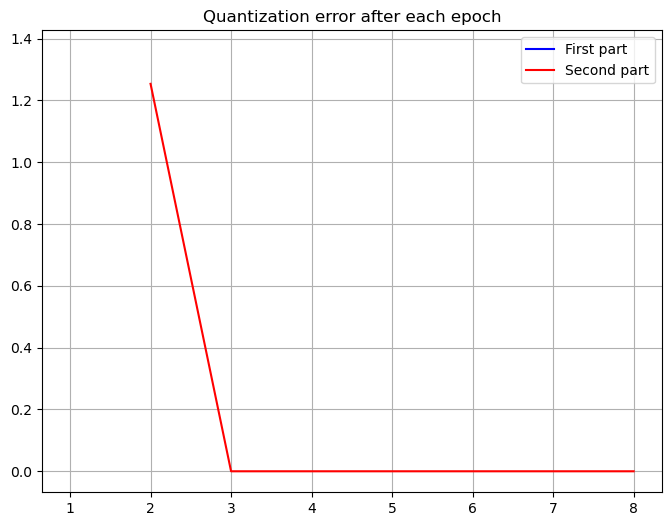

Training: 1 / 1 s

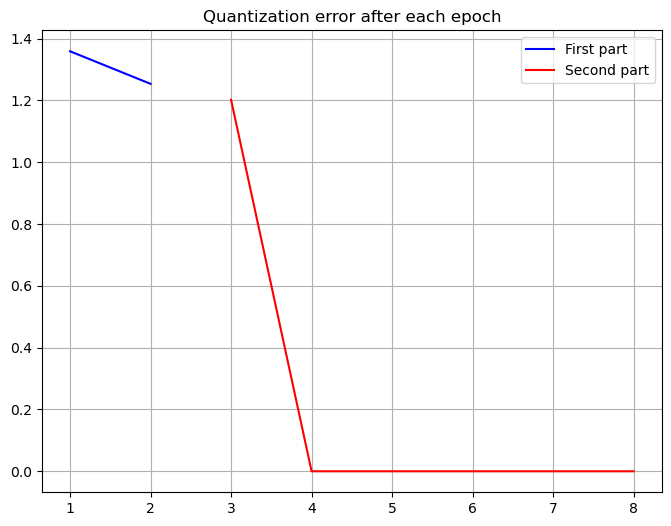

Training: 1 / 2 s

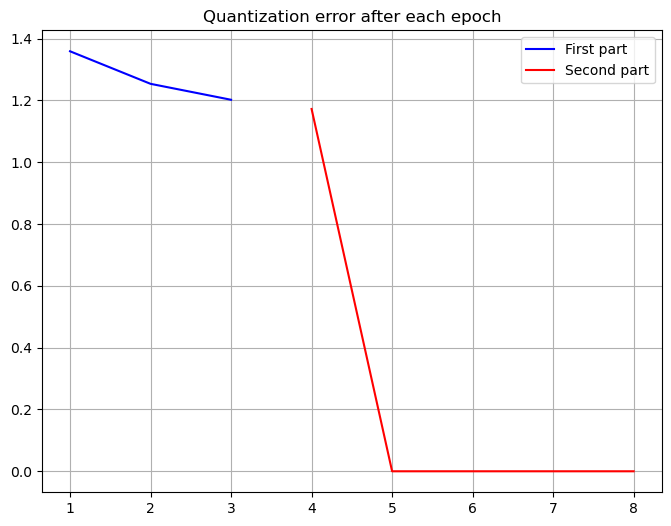

Training: 1 / 2 s

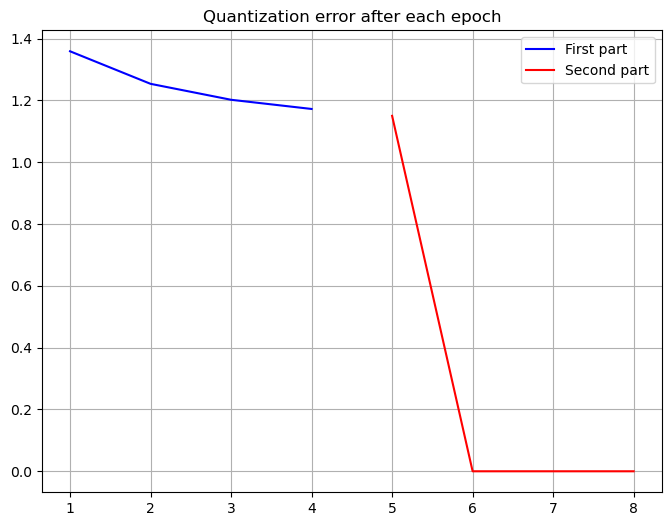

Training: 1 / 2 s

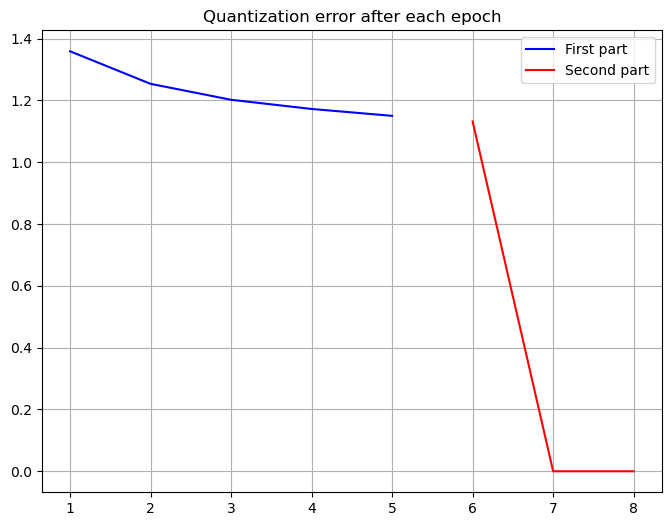

Training: 2 / 2 s

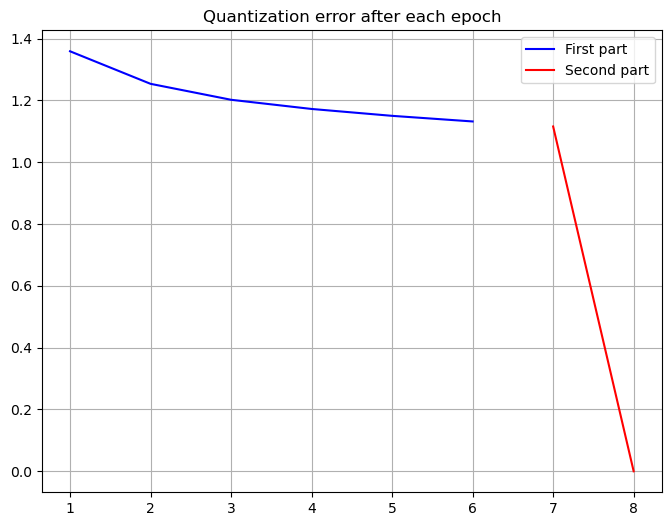

Training: 2 / 2 s

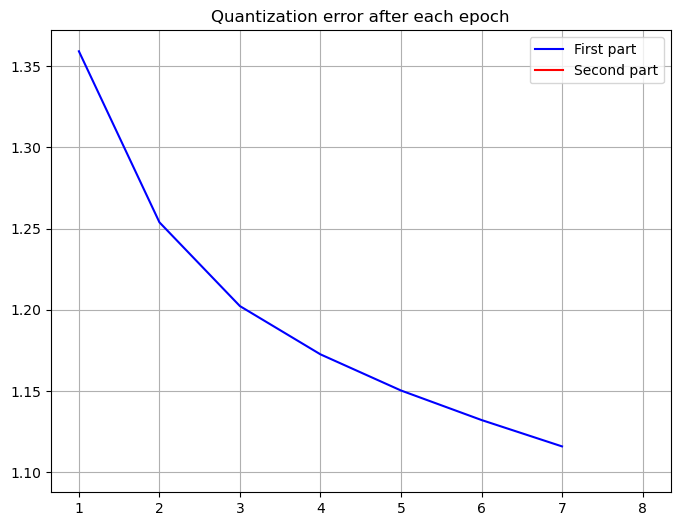



Final quantization error: 0.631
Final topographic error:  0.450


In [4]:
sMap = som_make(sData_controls_norm, *['lattice', 'shape', 'training', 'mapsize'],**{'lattice':'hexa', 'shape':'sheet', 'training': 'long','mapsize':'large'})

In [5]:
#find the best matching unit for each data point
Traj_train, Qerrs_train = som_bmus(sMap, sData_controls_norm, 'all')
Traj_train_coord = som_ind2sub(sMap, Traj_train[:,0])
Traj_train_coord = np.concatenate((Traj_train_coord, Qerrs_train[:,[0]]), axis=1)
line1 = np.concatenate((sMap['topol']['msize'], [0]))

Traj_LC, Qerrs_LC = som_bmus(sMap, sData_LC_norm_copy, 'all')
Traj_LC_coord = som_ind2sub(sMap, Traj_LC[:,0])
Traj_LC_coord = np.concatenate((Traj_LC_coord, Qerrs_LC[:,[0]]), axis=1)

Traj_ME, Qerrs_ME = som_bmus(sMap, sData_ME_norm_copy, 'all')
Traj_ME_coord = som_ind2sub(sMap, Traj_ME[:,0])
Traj_ME_coord = np.concatenate((Traj_ME_coord, Qerrs_ME[:,[0]]), axis=1)

In [6]:
# denormalize the weight vectors
M = som_denormalize(sMap['codebook'].copy(), *[sMap])

Traj_train, Qerrs_train = som_bmus(M, plotdata_controls.copy(), 'all')
Traj_train_coord = som_ind2sub(sMap, Traj_train[:,0])
Traj_train_coord = np.concatenate((Traj_train_coord, Qerrs_train[:,[0]]), axis=1)

Traj_LC, Qerrs_LC = som_bmus(M, plotdata_LC.copy(), 'all')
Traj_LC_coord = som_ind2sub(sMap, Traj_LC[:,0])
Traj_LC_coord = np.concatenate((Traj_LC_coord, Qerrs_LC[:,[0]]), axis=1)

Traj_ME, Qerrs_ME = som_bmus(M, plotdata_ME.copy(), 'all')
Traj_ME_coord = som_ind2sub(sMap, Traj_ME[:,0])
Traj_ME_coord = np.concatenate((Traj_ME_coord, Qerrs_ME[:,[0]]), axis=1)

c:\Users\Tijn\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Tijn\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 1.0, '2D Heatmap of FRAMES together with the Trajectories')

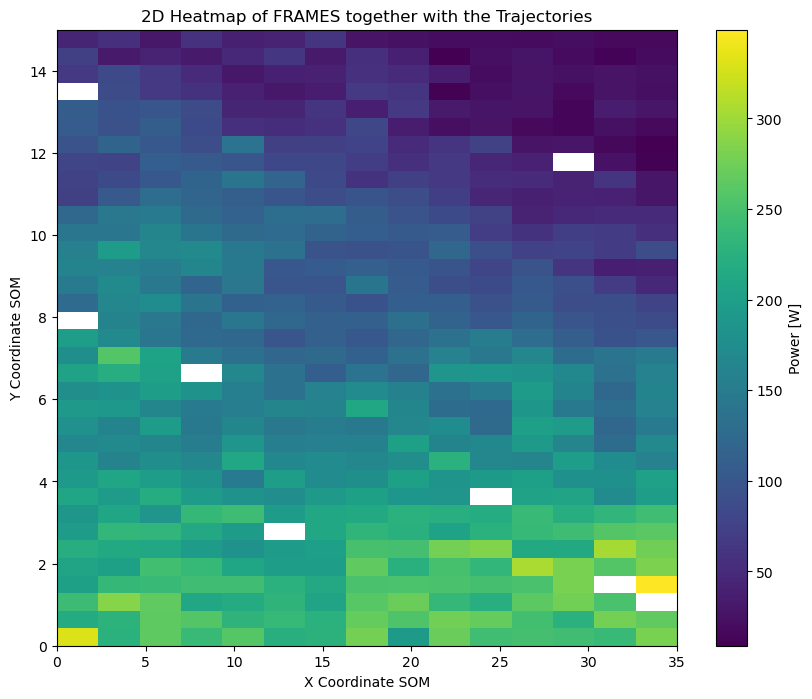

In [7]:
index = [[None for _ in range(line1[1])] for _ in range(line1[0])]
# Iterate over t and q using nested loops
for t in range(0, line1[1]):
    for q in range(0, line1[0]):
        # Calculate the index
        index[q][t] = np.where((Traj_train_coord[:,0] == q) & (Traj_train_coord[:,1] == t))[0]

# compute average Frame number per neuron
# Flatten index using list comprehension
index_reQE = [item for sublist in index for item in sublist]
# Number of frames (t)
num_repeats = len(plotdata_controls) // length_prime

## Create a linearly spaced vector from 1 to 101
frame = np.linspace(1, length_prime, length_prime)
FRAMES = np.tile(frame, (num_repeats, 1)).flatten()
FRAMES = FRAMES.reshape(-1, 1)

FRAMES_SOM1 = np.zeros((len(M), 1))
for r in range(len(M)):
    FRAMES_SOM1[r, 0] = np.mean(FRAMES[index_reQE[r]])

FRAMES_re = FRAMES_SOM1.reshape(line1[0], line1[1])

extent = [0, FRAMES_re.shape[0], 0, FRAMES_re.shape[1]]

plt.figure(figsize=(10, 8))
plt.imshow(FRAMES_re, aspect='auto', cmap='viridis', origin='lower', extent=extent)
plt.colorbar(label='Power [W]')
plt.xlabel('X Coordinate SOM')
plt.ylabel('Y Coordinate SOM')
plt.title('2D Heatmap of FRAMES together with the Trajectories')

MEAN_train range: X(0.0 to 31.0), Y(0.0 to 12.0)
MEAN_LC range: X(0.0 to 31.0), Y(0.0 to 13.0)
MEAN_ME range: X(0.0 to 32.0), Y(0.0 to 13.0)
FRAMES_re_normalized shape: (35, 15)
FRAMES_re shape: (35, 15)


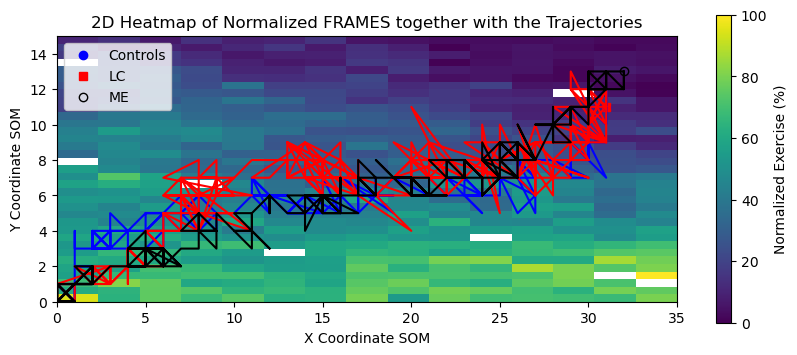

In [8]:
## EXPLORE THE MAP
x_train = np.reshape(Traj_train_coord[:, 0], (length_prime, -1), order='F')
y_train = np.reshape(Traj_train_coord[:, 1], (length_prime, -1), order='F') 
MEAN_train = np.column_stack((np.round(np.mean(x_train, axis=1)), np.round(np.mean(y_train, axis=1))))
STD_train = np.column_stack((np.round(np.std(x_train, axis=1)), np.round(np.std(y_train, axis=1))))

x_LC = np.reshape(Traj_LC_coord[:, 0], (length_prime, -1), order='F')
y_LC = np.reshape(Traj_LC_coord[:, 1], (length_prime, -1), order='F')
MEAN_LC = np.column_stack((np.round(np.mean(x_LC, axis=1)), np.round(np.mean(y_LC, axis=1))))
STD_LC = np.column_stack((np.round(np.std(x_LC, axis=1)), np.round(np.std(y_LC, axis=1))))

x_ME = np.reshape(Traj_ME_coord[:, 0], (length_prime, -1), order='F')
y_ME = np.reshape(Traj_ME_coord[:, 1], (length_prime, -1), order='F')
MEAN_ME = np.column_stack((np.round(np.mean(x_ME, axis=1)), np.round(np.mean(y_ME, axis=1))))
STD_ME = np.column_stack((np.round(np.std(x_ME, axis=1)), np.round(np.std(y_ME, axis=1))))

marker_sizes = np.ones(min(length_prime, length_prime)) * 5  # Initialize all markers to size 5
marker_sizes[0] = 7  # Make the first marker larger

print(f"MEAN_train range: X({MEAN_train[:, 0].min()} to {MEAN_train[:, 0].max()}), Y({MEAN_train[:, 1].min()} to {MEAN_train[:, 1].max()})")
print(f"MEAN_LC range: X({MEAN_LC[:, 0].min()} to {MEAN_LC[:, 0].max()}), Y({MEAN_LC[:, 1].min()} to {MEAN_LC[:, 1].max()})")
# Normalize the FRAMES_re array to a range of 0 to 100
FRAMES_re_normalized = (FRAMES_re - np.nanmin(FRAMES_re)) / (np.nanmax(FRAMES_re) - np.nanmin(FRAMES_re)) * 100

print(f"MEAN_ME range: X({MEAN_ME[:, 0].min()} to {MEAN_ME[:, 0].max()}), Y({MEAN_ME[:, 1].min()} to {MEAN_ME[:, 1].max()})")
print(f"FRAMES_re_normalized shape: {FRAMES_re_normalized.shape}")
extent = [0, FRAMES_re_normalized.shape[0], 0, FRAMES_re_normalized.shape[1]]

plt.figure(figsize=(10, 4)) 
plt.imshow(FRAMES_re_normalized, aspect='auto', cmap='viridis', origin='lower', extent=extent)
plt.colorbar(label='Normalized Exercise (%)')
plt.xlabel('X Coordinate SOM')
plt.ylabel('Y Coordinate SOM')
plt.title('2D Heatmap of Normalized FRAMES together with the Trajectories')
print(f"FRAMES_re shape: {FRAMES_re.shape}")
extent = [0, FRAMES_re.shape[0], 0, FRAMES_re.shape[1]]

plt.plot(MEAN_train[0, 0], MEAN_train[0, 1], 'bo', label='Controls')
plt.plot(MEAN_LC[0, 0], MEAN_LC[0, 1], 'rs', label='LC')
plt.plot(MEAN_ME[0, 0], MEAN_ME[0, 1], 'ko', label='ME', markerfacecolor='none')

plt.plot(MEAN_train[:, 0], MEAN_train[:, 1], 'b-', markersize=4)
plt.plot(MEAN_LC[:, 0], MEAN_LC[:, 1], 'r-', markersize=4)
plt.plot(MEAN_ME[:, 0], MEAN_ME[:, 1], 'k-', markersize=4)

plt.gca().set_aspect('equal', adjustable='box')

plt.legend()
plt.show()
breakpoint()


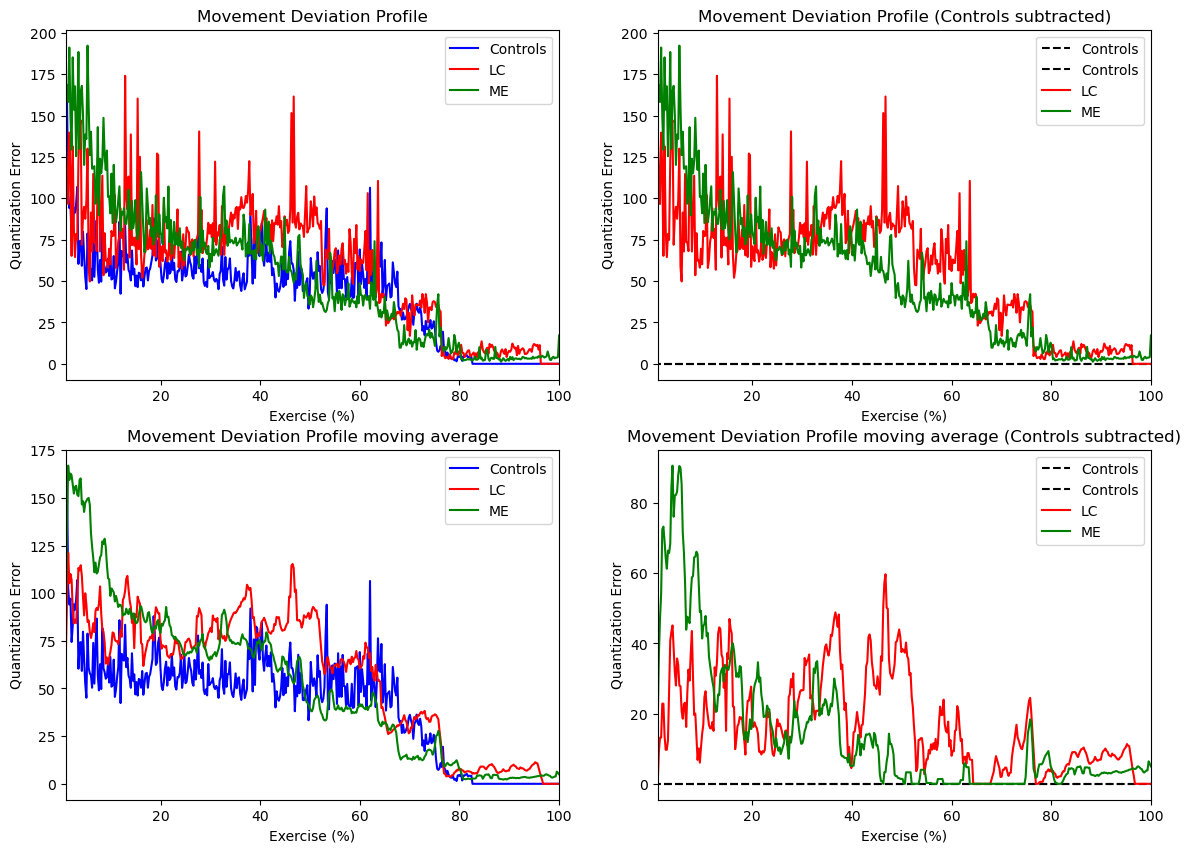

In [ ]:
## MOVEMENT DEVIATION PROFILE
# here the aim is to find the difference in Quantization Errors of the train and the test set
# relative to the SOM. These errors are then compared and illustrated into the so-called Movement 
# Deviation Profile (MDP)

# Reshape the first column of Traj_train
error_train = np.reshape(Traj_train_coord[:, 2], (length_prime, -1), order='F')
MEAN_error_train = np.mean(error_train, axis=1)
error_LC = np.reshape(Traj_LC_coord[:, 2], (length_prime, -1), order='F')
MEAN_error_LC = np.mean(error_LC, axis=1)
error_ME = np.reshape(Traj_ME_coord[:, 2], (length_prime, -1), order='F')
MEAN_error_ME = np.mean(error_ME, axis=1)


fig, axs = plt.subplots(2, 2, figsize=(14, 10))

x =np.linspace(1,100, length_prime)

subplot_mdp(axs, (0, 0), x, {'train': MEAN_error_train, 'LC': MEAN_error_LC, 'ME': MEAN_error_ME}, convolve=False, norm=False)
subplot_mdp(axs, (0, 1), x, {'train': MEAN_error_train, 'LC': MEAN_error_LC, 'ME': MEAN_error_ME}, convolve=False, norm=True)
subplot_mdp(axs, (1, 0), x, {'train': MEAN_error_train, 'LC': MEAN_error_LC, 'ME': MEAN_error_ME}, convolve=True, norm=False)
subplot_mdp(axs, (1, 1), x, {'train': MEAN_error_train, 'LC': MEAN_error_LC, 'ME': MEAN_error_ME}, convolve=True, norm=True)


In [13]:
# statistical analysis of the Movement Deviation Profile
# use statsmodels.formula.api as smf to perform the analysis of time series data
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests

# Create a DataFrame with the data
df_controls = pd.DataFrame({'Time': x, 'Quantization Error': MEAN_error_train, 'Group': 'Controls'})
df_lc = pd.DataFrame({'Time': x, 'Quantization Error': MEAN_error_LC, 'Group': 'LC'})
df_me = pd.DataFrame({'Time': x, 'Quantization Error': MEAN_error_ME, 'Group': 'ME'})
df = pd.concat([df_controls, df_lc, df_me])
df

# Perform the analysis of time series data
model = smf.mixedlm("Q('Quantization Error') ~ Group * Time", df, groups=df["Group"])
result = model.fit()
pvas = result.pvalues
# compare LC and ME
df_LC_ME = df[df['Group'].isin(['LC', 'ME'])]
model = smf.mixedlm("Q('Quantization Error') ~ Group * Time", df_LC_ME, groups=df_LC_ME["Group"])
result = model.fit()
pvas['Intercept LC:ME'] = result.pvalues[1]
pvas['Interaction LC:ME'] = result.pvalues[3]
pvas.drop(['Intercept', 'Time', 'Group Var'], inplace=True)
# rename to paper readable names, i.e. remove the Group[T.] part and replace it with intercept difference or interaction difference
pvas.rename(index={'Group[T.LC]': 'Intercept Controls:LC', 'Group[T.ME]': 'Intercept Controls:ME', 'Group[T.LC]:Time': 'Interaction Controls:LC', 'Group[T.ME]:Time': 'Interaction Controls:ME'}, inplace=True)
# reorder columns: first all intercepts, then all interactions
pvas = pvas[['Intercept Controls:LC', 'Intercept Controls:ME', 'Intercept LC:ME', 'Interaction Controls:LC', 'Interaction Controls:ME', 'Interaction LC:ME']]

reject, corrected_pvals, _, _ = multipletests(pvas, alpha=0.05, method='fdr_bh')
corrected_pvals = [round(pval, 4) for pval in corrected_pvals]
# add ** to corrected pvals that are smaller than 0.001 and * to corrected pvals that are smaller than 0.05
corrected_pvals = [f'{pval}**' if pval < 0.01 else f'{pval}*' if pval < 0.05 else pval for pval in corrected_pvals]
# create a DataFrame with the p-values and the corrected p-values
pval_df = pd.DataFrame({'p-value': pvas, 'Corrected p-value': corrected_pvals})
pval_df

c:\Users\Tijn\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Tijn\AppData\Local\Temp\ipykernel_11308\2956652175.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pvas['Intercept LC:ME'] = result.pvalues[1]
C:\Users\Tijn\AppData\Local\Temp\ipykernel_11308\2956652175.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pvas['Interaction LC:ME'] = result.pvalues[3]


,p-value,Corrected p-value
Intercept Controls:LC,2.746310e-01,0.3296
Intercept Controls:ME,1.232880e-01,0.1849
Intercept LC:ME,6.704768e-01,0.6705
Interaction Controls:LC,4.155972e-09,0.0**
Interaction Controls:ME,2.867470e-41,0.0**
Interaction LC:ME,6.663617e-13,0.0**
